In [35]:
from IPython.display import Image
#Image(filename='filepath/filename.jpg')

<h1 style="text-align: center;"> Time-Series Modeling </p>

## Table of contents
1. [Problem Domain](#Problem-domain)
2. [Required Libraries](#Required-libraries)
3. [Gas Well Data](#Gas-Well-Data)
4. [Data Exploration](#Data-Exploration)
5. [Visualizations](#Visualizations)
6. [Resampling](#Resampling)<br>
7. [Decomposition](#Decomposition)
8. [Time Series Stationarity](#Time-Series-Stationarity)
9. [Making Time Series Stationary](#Making-Time-Series-Stationary)
10. [Autocorrelations and Partial Autocorrelations](#Autocorrelations-and-Partial-Autocorrelations)
11. [ARIMA Modelling](#ARIMA-Modelling)
12. [Conclusion](#Conclusion)

## Problem Domain

[[ go back to the top ]](#Table-of-contents)

This notebook will introduce time series processing methods for time series modelling. In this notebook, we will work with the gas well time series data to generate insights. We have one year of flow and casing pressure data from a hypothetical gas well with a plunger system. 

Understanding the historical performance of the well and operating metrics is important to make decisions for optimizing the production. Identifying trends and impact of different set points and operation upsets will help operators to make better decisions on how to operate the well. Not every operator and data scientist has access to the reservoir simulation software and they are highly technical and expensive to work with, whereas historical data is available to everyone. The purpose of this analysis is not to simulate the production of the gas well since there are many factors that need to be taken into consideration. We intend to give data scientists and operators a tool to quickly identify patterns and generate insights and use it as a lense in their day to day decision making.

This is Part II of the time series analysis. For more about time series processing techniques. See the template notebook "TimeSeries_Processing". 

<br>**Note:** The data set we're working with is synthetically made for demonstration purposes.

## Required Libraries

[[ go back to the top ]](#Table-of-contents)

This notebook uses several Python packages that come standard with the Anaconda Python distribution. The primary libraries that we'll be using are:

* **datetime**: Native Python module to operate with Datetime objects.
* **NumPy**: Provides a fast numerical array structure and helper functions.
* **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
* **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
* **Seaborn**: Advanced statistical plotting library.
* **statsmodels**: The package that allows users to explore data, estimate statistical models, and perform statistical tests.
* **SciPy**: A library for statistical fitting, modeling, and analysis

In [37]:
# Load required packages 
import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
#from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA
from scipy import signal
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

## Gas Well Data

[[ go back to the top ]](#Table-of-contents)

This dataset contains a year's worth of minute-frequency data from a gas well on flow metrics and casing pressure. A total of 481680 records were collected from 2019-03-01 to 2020-01-29. The gas flow data is measured in E3M3, casing pressure and line pressure is measured in kPa. 

#### Load Data

In [5]:
# Please do not change the file path if wish to use default data
df = pd.read_csv('./sample_flow.csv', thousands = ',', index_col='Timestamp', parse_dates = ['Timestamp'])
df.head()

,Casing_Pressure_kPa,Flow_E3M3,Line_Pressure_kPa,CLDP_kPa
Timestamp,,,,
2019-03-01 00:00:00,1385.582115,14.382364,961.09,424.492115
2019-03-01 00:01:00,1384.233459,15.582364,954.99,429.243459
2019-03-01 00:02:00,1384.903200,15.162364,958.43,426.473200
2019-03-01 00:03:00,1385.126330,15.222364,959.93,425.196330
2019-03-01 00:04:00,1386.334705,15.712364,956.37,429.964705


In [2]:
# Please do not change the file path if wish to use default data
df = pd.read_csv('/usr/share/jupyter/notebook_templates/digitalhub/dataset/flow.csv', thousands = ',', index_col='Timestamp', parse_dates = ['Timestamp'])
df.head()

,Casing_Pressure_kPa,Flow_E3M3,Line_Pressure_kPa
Timestamp,,,
2019-03-01 00:00:00,1385.582115,14.382364,961.09
2019-03-01 00:01:00,1384.233459,15.582364,954.99
2019-03-01 00:02:00,1384.903200,15.162364,958.43
2019-03-01 00:03:00,1385.126330,15.222364,959.93
2019-03-01 00:04:00,1386.334705,15.712364,956.37


#### Calculate CLDP

Casing-line differential pressure is an important metric in the operation of the plunger lift. We can calculate it but subtracting the line pressure from the casing pressure.

In [6]:
df['CLDP_kPa'] = df.Casing_Pressure_kPa - df.Line_Pressure_kPa
df.head()

,Casing_Pressure_kPa,Flow_E3M3,Line_Pressure_kPa,CLDP_kPa
Timestamp,,,,
2019-03-01 00:00:00,1385.582115,14.382364,961.09,424.492115
2019-03-01 00:01:00,1384.233459,15.582364,954.99,429.243459
2019-03-01 00:02:00,1384.903200,15.162364,958.43,426.473200
2019-03-01 00:03:00,1385.126330,15.222364,959.93,425.196330
2019-03-01 00:04:00,1386.334705,15.712364,956.37,429.964705


## Data Exploration

[[ go back to the top ]](#Table-of-contents)

In [38]:
# df.describe()
#profile = ProfileReport(df, title="Gas Well Plunger Profiling", interactions=None)
#profile.to_widgets()

> *Observations*
>
> In the profiling we see that we do not have to deal with missing values. However, all pressure metrics seems to have tailed off extreme values. 

## Visualizations

[[ go back to the top ]](#Table-of-contents)

In [8]:
plt.rcParams["figure.figsize"] = (20,10)
plt.style.use('seaborn')

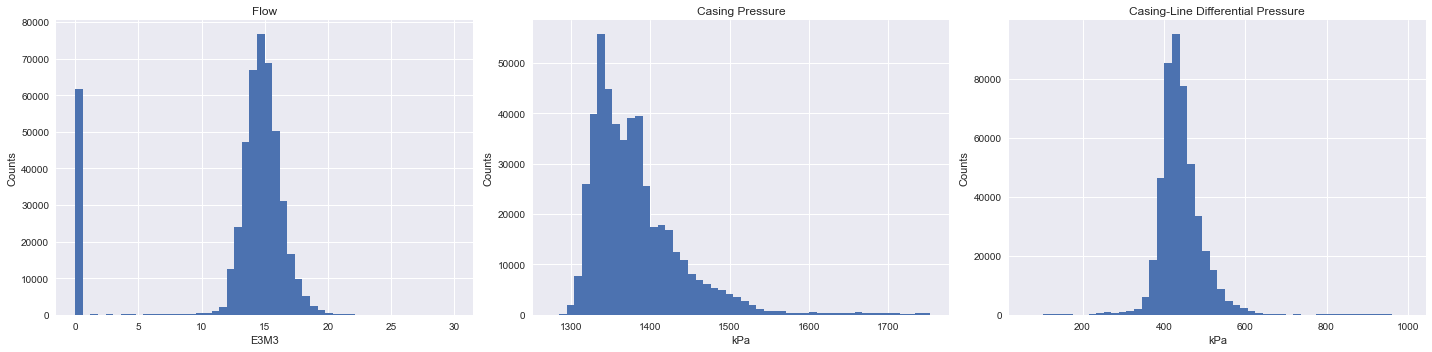

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].hist(df.Flow_E3M3, bins = 50)
ax[1].hist(df.Casing_Pressure_kPa, bins = 50)
ax[2].hist(df.CLDP_kPa, bins = 50)

ax[0].set_title('Flow')
ax[0].set_ylabel('Counts')
ax[0].set_xlabel('E3M3')
ax[1].set_title('Casing Pressure')
ax[1].set_ylabel('Counts')
ax[1].set_xlabel('kPa')
ax[2].set_title('Casing-Line Differential Pressure')
ax[2].set_ylabel('Counts')
ax[2].set_xlabel('kPa')
plt.tight_layout()

> *Observations*
>
> By plotting the histogram of the flow, casing pressure and CLDP, we can see the characteristic of each variable
> - Flow seems to center around 15 E3M3, but with a lot of zero-values that corresponds to the shut-in time during each plunger cycle. There are also scattered values between 0 to 10 E3M3 that suggests further cleaning or investigations.
> - Casing pressure seems to be right-skewed with many extreme high values which may pose problems in downstream analysis. 
> - CLDP seems to be symmetrical, however both ends seems to have scattered extreme values that may require more investigations

### Look at a Zoomed-In Window

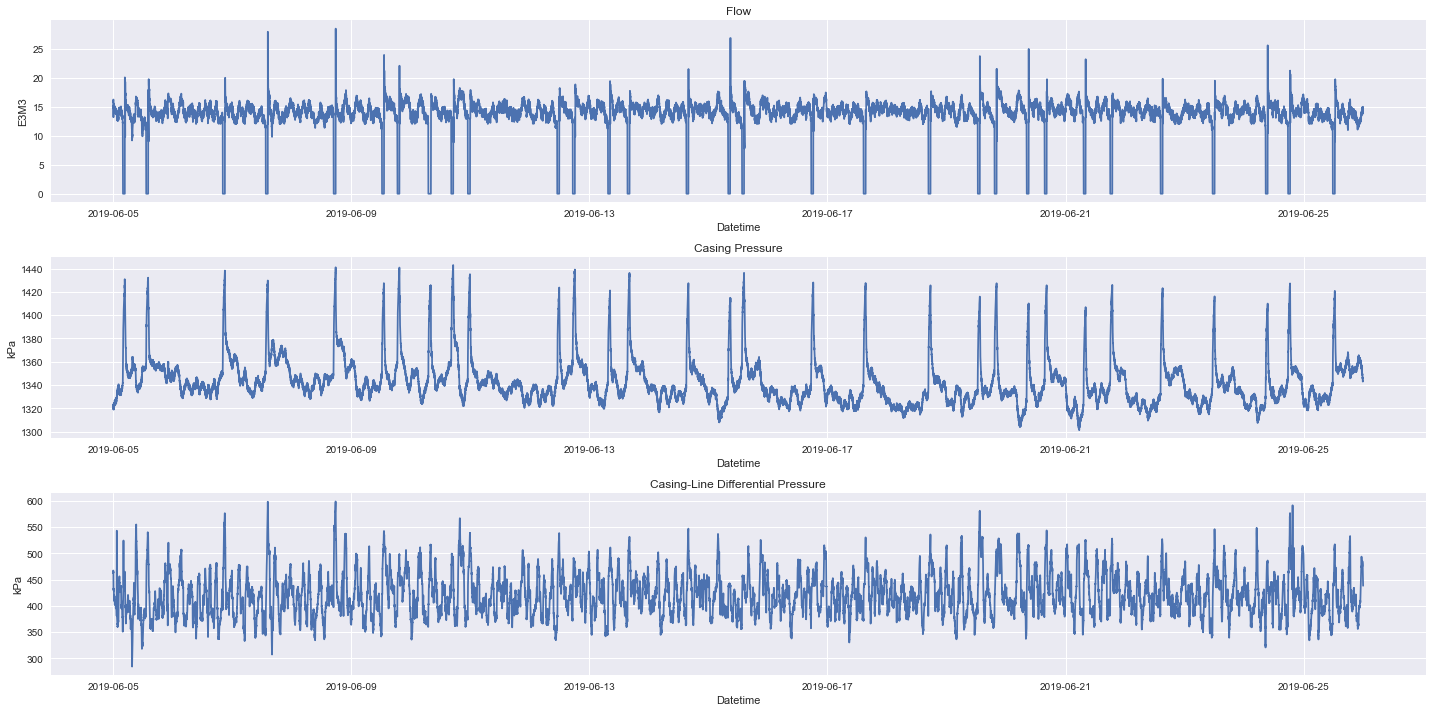

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(20,10))
start = '2019-06-05'
end = '2019-06-25'

ax[0].plot(df.loc[start:end ,'Flow_E3M3'])
ax[1].plot(df.loc[start:end, 'Casing_Pressure_kPa'])
ax[2].plot(df.loc[start:end, 'CLDP_kPa'])
ax[0].set_title('Flow')
ax[0].set_ylabel('E3M3')
ax[0].set_xlabel('Datetime')
ax[1].set_title('Casing Pressure')
ax[1].set_ylabel('kPa')
ax[1].set_xlabel('Datetime')
ax[2].set_title('Casing-Line Differential Pressure')
ax[2].set_ylabel('kPa')
ax[2].set_xlabel('Datetime')
plt.tight_layout()

> *Observations*
> 
> When we zoomed into 20-days, we can see the relationship between the casing pressure and the flow more clearly. The pits in the flow data shows the shut-in time of the well while the plunger system allows the casing pressure to build up. We see the cycles in the casing pressure corresponds to the flow and shut-in of the well. On the other hand, the CLDP's peaks is not distinctive, but we can still see the peaks and frequency corresponding to each cycle at a careful look.

### Look at the Entire Data

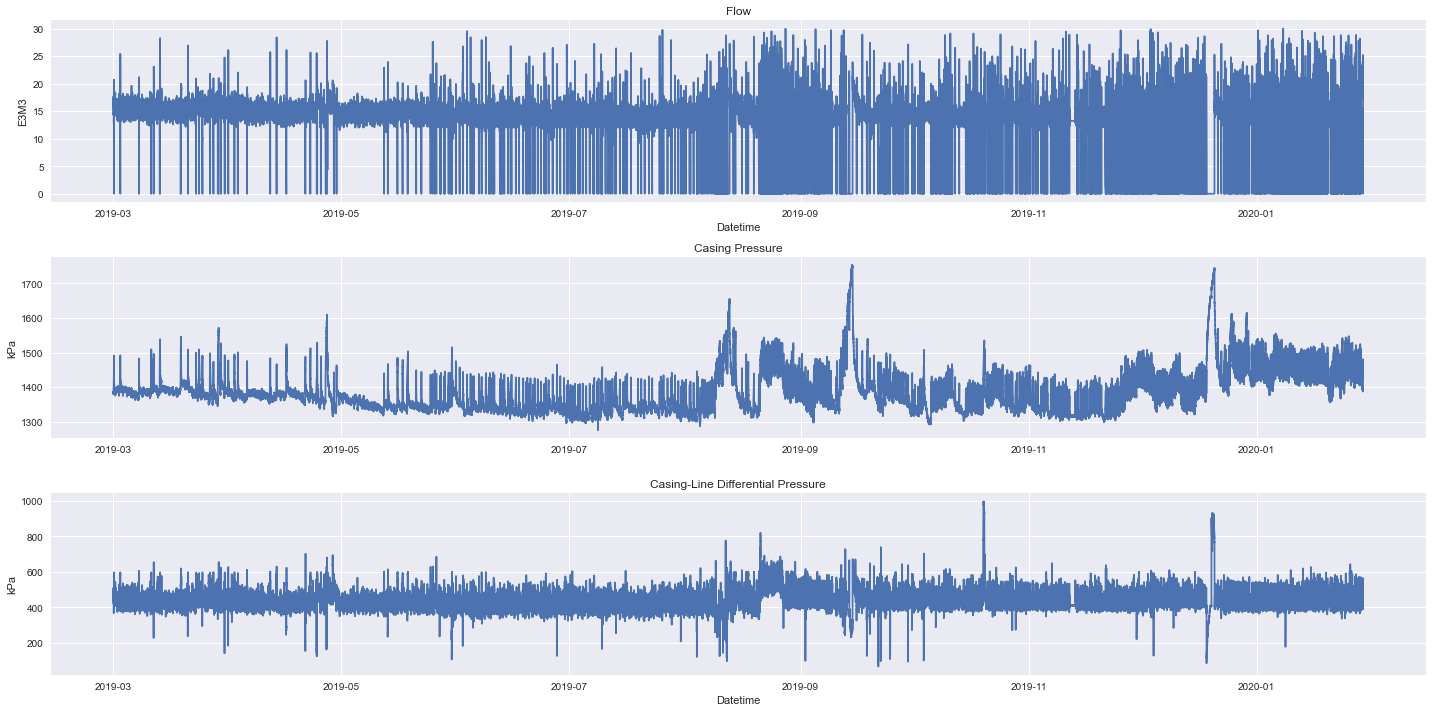

In [11]:
fig, ax = plt.subplots(3,1, figsize=(20,10))
ax[0].plot(df.Flow_E3M3)
ax[1].plot(df.Casing_Pressure_kPa)
ax[2].plot(df.CLDP_kPa)
ax[0].set_title('Flow')
ax[0].set_ylabel('E3M3')
ax[0].set_xlabel('Datetime')
ax[1].set_title('Casing Pressure')
ax[1].set_ylabel('kPa')
ax[2].set_xlabel('Datetime')
ax[2].set_title('Casing-Line Differential Pressure')
ax[2].set_ylabel('kPa')
ax[2].set_xlabel('Datetime')

plt.tight_layout()
plt.show()

> *Observations*
>
> An entire year's worth of minute data is very condensed. Although we can see some significant impacts such as the big casing pressure build up at 2019 December, it is very difficult to get big picture insights from the entire dataset. On one hand, this is due to nature of the plunger cycle with frequent casing pressure peaks and flow pitting to zero. On the other hand, the high frequency makes it hard to dissect. However with some simple processing we can get the big-picture insights from this seemingly difficult data. 


## Resampling

[[ go back to the top ]](#Table-of-contents)

Resampling is a common technique used to change the frequency of the data while preserving the overall patterns (trend, seasonality). This is a technique often used to upsample and intrapolate data into higher frequency or to downsample to summarize the data. 

Jason Brownlee's blog on [How To Resample and Interpolate Your Time Series Data With Python](https://machinelearningmastery.com/resample-interpolate-time-series-data-python/) provides a more in-depth read about the resampling technique.

In our analysis here, we will downsample to generate more understandable view of our dataset.

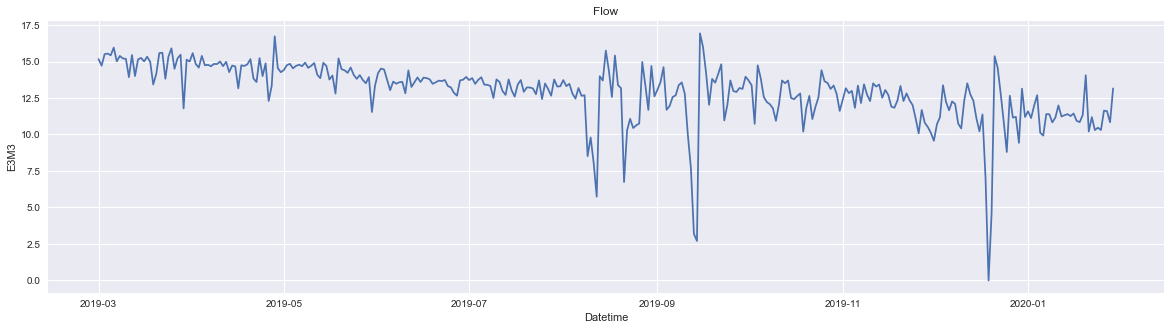

In [12]:
# Resampling to day-frequency data using the Pandas module
## Argument "D" refers to the target frequency
## .mean() indicates using the average of the hour
ts = df.Flow_E3M3.resample('D', label='left').mean()

# Plot
plt.figure(figsize = (20,5))
plt.plot(ts)
plt.title('Flow')
plt.xlabel('Datetime')
plt.ylabel('E3M3')
plt.show()

> *Observations*
>
> We can clearly see a downward trend where the flow is slowing depleting overtime. Additionally it also became very obvious on intervals where the well perhaps is functioning out of normality. We can quickly identify interval for investigations if we were doing abnormality analysis. Additionally, this is a very simple and inexpensive analysis to get a quick insight on the big-picture of the gas well plunger
>
> **For the rest of the analysis, we will focus on working with the resampled flow data**

We will subset the data up until 2019-08-08 where the flow was relative stable for model building and analysis. The latter of the data shows great deviations that may be result of maintenance events, change of operations, etc. Which is not suitable for forecasting model building.

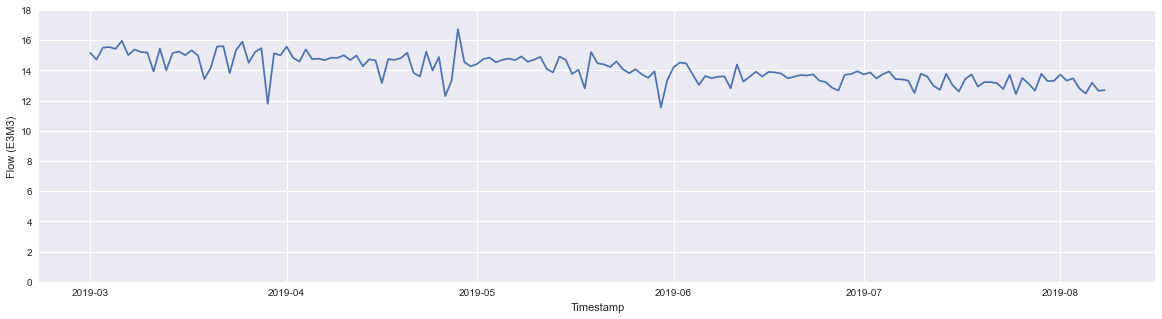

In [13]:
ts_sub = ts[:'2019-08-08']
plt.figure(figsize = (20,5))
plt.plot(ts_sub)
plt.ylim(0,18)
plt.xlabel('Timestamp')
plt.ylabel('Flow (E3M3)')
plt.show()

## Decomposition

[[ go back to the top ]](#Table-of-contents)

In the most simplistic form, a time series is made out of three components: trend, seasonality, and residuals. 
- Trend: The general pattern of progress (eg. The cumulative number of tweets overtime)
- Seasonality: Cyclic pattern of progress (eg. Changes responding to four seasons annually)
- Residual: the remaining effects in an observation not contributed by trend or seasonality. This may be noise or other random processes. The residuals is assumed to be stationary (not dependent on time), and is an important aspect to time series modelling and forecasting

A time series may also be additive or multiplicative. 
- Additive: $n_{t} = trend + seasonality + residual$
- Multiplicative: $n_{t} = trend * seasonality * residual$

The most obvious difference between an additive and multiplicative model is the increase of variance overtime in multiplicative models. Whereas the variance in additive model is relatively constant. 

The left is an example of *additive* time series and the right is an example of *multiplicative* time series. Image from [Data Camp](https://campus.datacamp.com/courses/arima-models-in-python/chapter-4-seasonal-arima-models?ex=12).

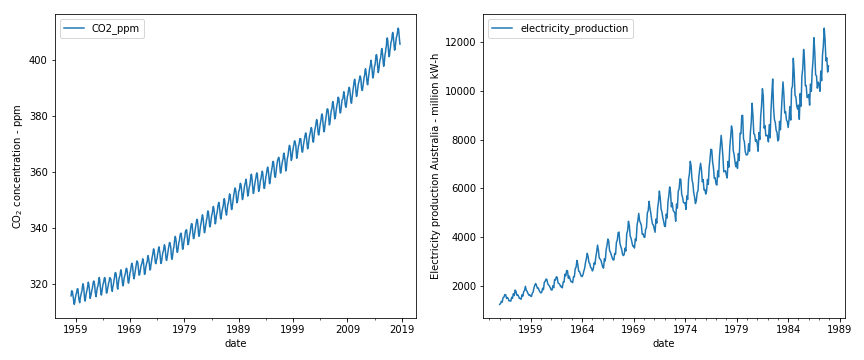

#### Decompose with Python Module

Python offers different analytic modules that can be used to quickly decompose the series into the three components. However as with the usage of any modules, you will require to have knowledge in the configurations, and algorithms to make the correct decomposition of your data. 

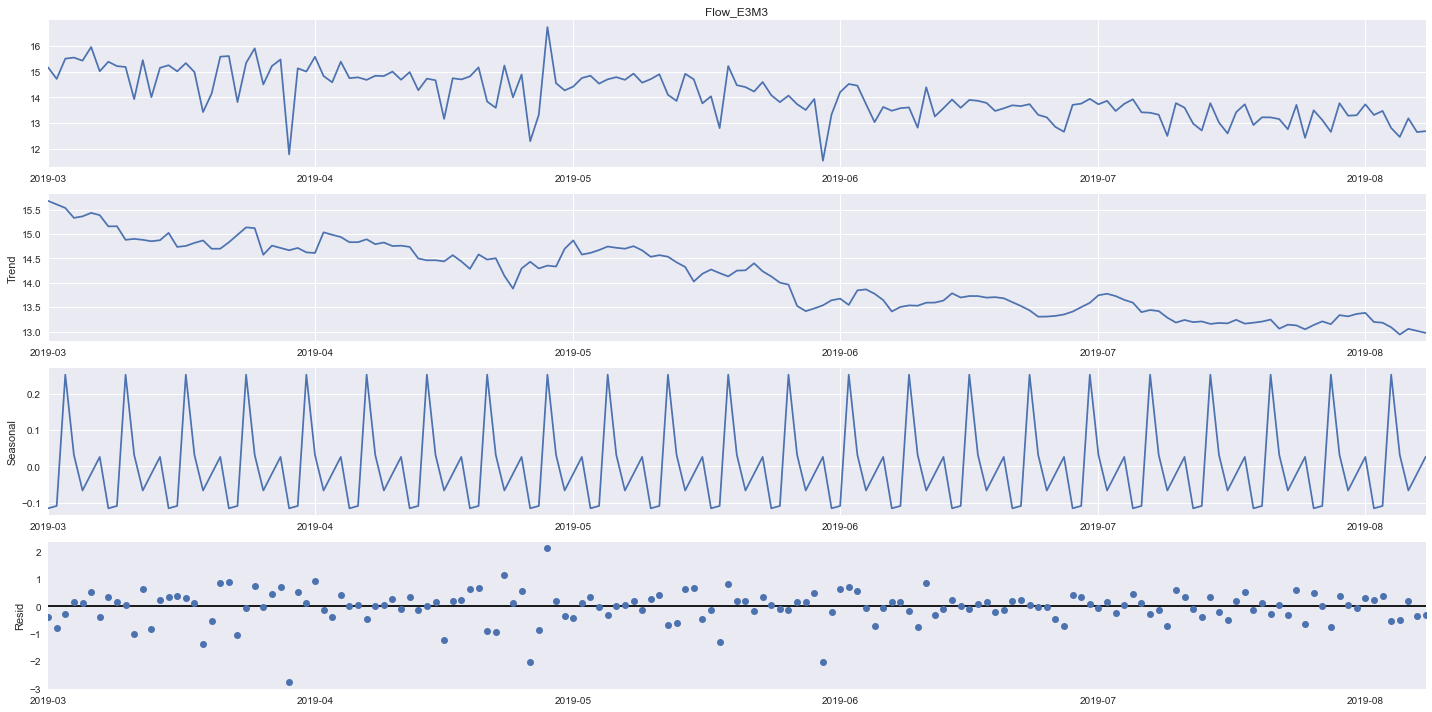

In [15]:
# Decompost the Time Series into Trend, Seasonality and Residuals

decomposed = sm.tsa.seasonal_decompose(ts_sub, model = 'additive', extrapolate_trend='freq')
plt.rc("figure", figsize=(20,10))
fig = decomposed.plot()
plt.grid()

trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

> *Observations*
>
> With the decomposed data, we see the expected downward trend in the flow data. The seasonal aspect of the data is not expected, we may be more conservative on getting insights or making decision about the suggested seasonality.

> **TIPS**
>
> Decomposition is an important concept in time series forecast modelling. But often we also use decomposition in the begining of an analysis to gain quick insights into the time series. Particularly with complex time series that may involve multiple trends and multiple seasonality component, decomponsition becomes important to understanding what are the different influencing factor that causes our time series to progress in the way it does. 
>
> The importance of the residuals, which is also the stationary component of the time series, is not yet apparent. However, do keep in mind that this is a critical component in building forecast models. It represents the uncertainties and random processes, which is the basis of the time series. 

## Time Series Stationarity


[[ go back to the top ]](#Table-of-contents)


The first step to build an ARIMA model is to make the time series **stationary**.

Why?

Because, term ‘Auto Regressive’ in ARIMA means it is a linear regression model that uses its own lags as predictors. Linear regression models, as you know, work best when the predictors are not correlated and are independent of each other.

- A stationary time series is one whose properties do not depend on the time at which the series is observed i.e its statistical properties such as mean, variance remain constant over time.
- Intuitively, we can say that if a time series has a particular behaviour over time, there is a very high probability that it will follow the same in the future. 
- The theories related to stationary series are more mature and easier to implement as compared to non-stationary series. Most statistical models require the series to be stationary to make effective and precise predictions.

Reference: https://otexts.com/fpp2/stationarity.html

A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time.

Some cases can be confusing — a time series with cyclic behaviour (but with no trend or seasonality) is stationary. This is because the cycles are not of a fixed length, so before we observe the series we cannot be sure where the peaks and troughs of the cycles will be.

In general, a stationary time series will have no predictable patterns in the long-term. Time plots will show the series to be roughly horizontal (although some cyclic behaviour is possible), with constant variance.

In the following figues, only (b) and (g) are stationary series. Seasonality rules out series (d), (h) and (i). Trends and changing levels rules out series (a), (c), (e), (f) and (i). Increasing variance also rules out (i).

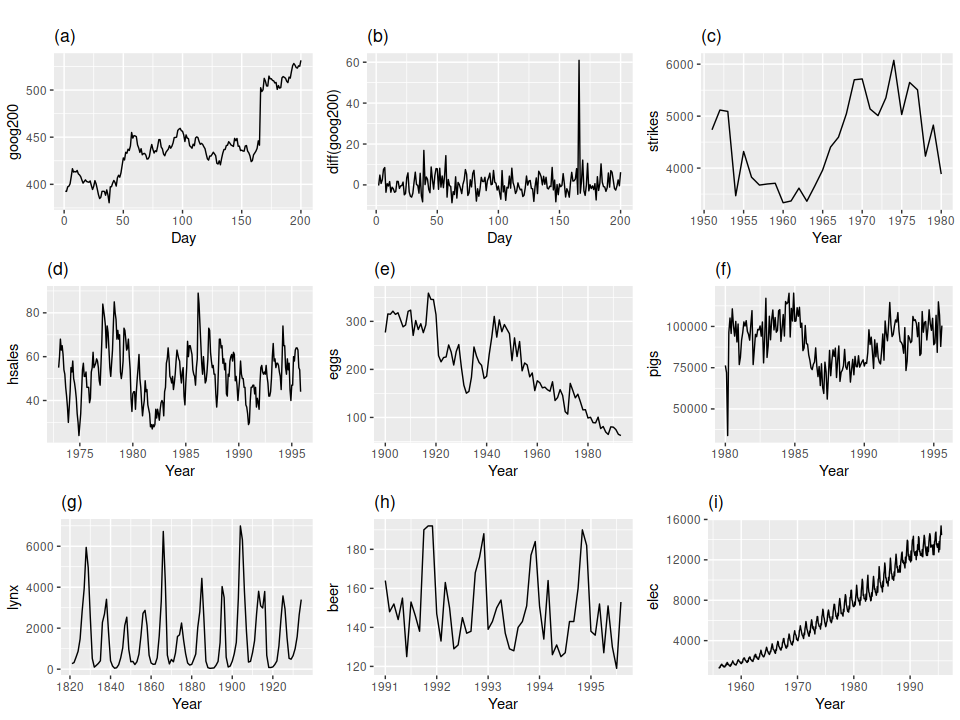

__Check if the time series is stationarity or not:__

- __Rolling Statistics__: We can plot the moving average or moving variance and see if it varies with time. Moving average/variance is for any instant ‘t’, the average/variance of the last year, i.e. last 12 months.
- __Augmented Dickey-Fuller Test:__ This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the Time Series is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. 
  - Null Hypothesis (H0): The time series is not stationary. <br>
  - Alternate Hypothesis (H1): The null hypothesis is rejected with p value below the threshold, indicates the time series is stationary; 

p-value > Threshold: Fail to reject the null hypothesis (H0), the data is non-stationary. <br>
p-value <= Threshold: Reject the null hypothesis (H0), the data is stationary.
The most common threshold value used is 0.05.

In [17]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=10).mean()
    rolstd = timeseries.rolling(window=10).std()

    #Plot rolling statistics:
    plt.figure(figsize = (20,5))
    orig = plt.plot(timeseries, color='blue',label='Actual Series')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

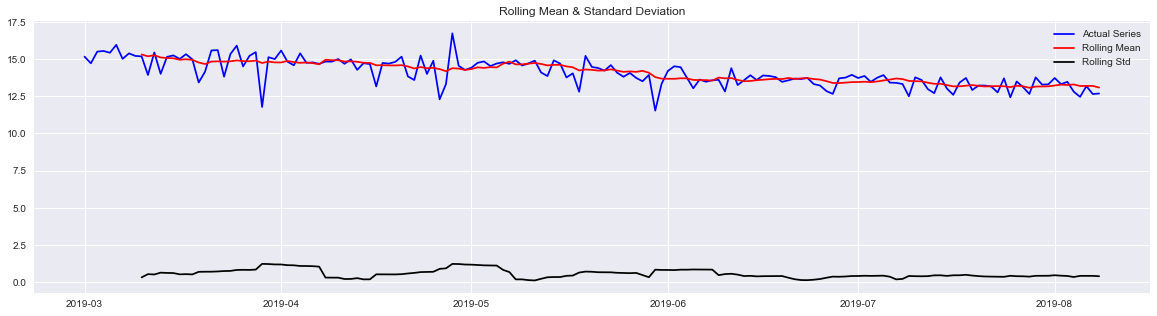

Results of Dickey-Fuller Test:
Test Statistic                  -1.188117
p-value                          0.678687
#Lags Used                       9.000000
Number of Observations Used    151.000000
Critical Value (1%)             -3.474416
Critical Value (5%)             -2.880878
Critical Value (10%)            -2.577081
dtype: float64


In [18]:
test_stationarity(ts_sub)

> **Insights**
>
> Without any additional processings, the flow data is not stationary. This is identified by the decreased rolling mean and that we've accepted the Dickey-Fuller null hypothesis that the station is not stationary.

## Making Time Series Stationary

[[ go back to the top ]](#Table-of-contents)


There are 2 major reasons behind non-stationarity of a Time Series :

1. __Trend__ – varying mean over time. In this case on average, the vibrations are growing over time.
2. __Seasonality__ – variations at specific time-windows. The equipment might have a tendency to encounter different vibrations in a particular month because of seasonal load factor.

**General Techniques to Make Series Stationary**
- Differencing the series in orders >=1
- Log transformation of the series
- nth-Root transformation of the series

**Detrend the Series**

- Subtract the line of best fit
- Subtract the trend component from time series decomposition
- Subtract the from the overall mean

**Remove Seasonality**

- Take a moving average with length as the seasonal window. This will smoothen in series in the process.
- Seasonal difference the series (subtract the value of previous season from the current value)

*If the model is multiplicative, do division of the trend and seasonality components*

### Differencing

[[ go back to the top ]](#Table-of-contents)


The most common approach is to difference it. That is, subtract the previous value from the current value. Sometimes, depending on the complexity of the series, more than one differencing may be needed.

The value of d, therefore, is the minimum number of differencing needed to make the series stationary. And if the time series is already stationary, then d = 0.

In [19]:
# Create a differenced series
def difference(dataset, interval=1):
    difference = dataset-dataset.shift(interval)
        
    return difference.dropna(inplace= False)

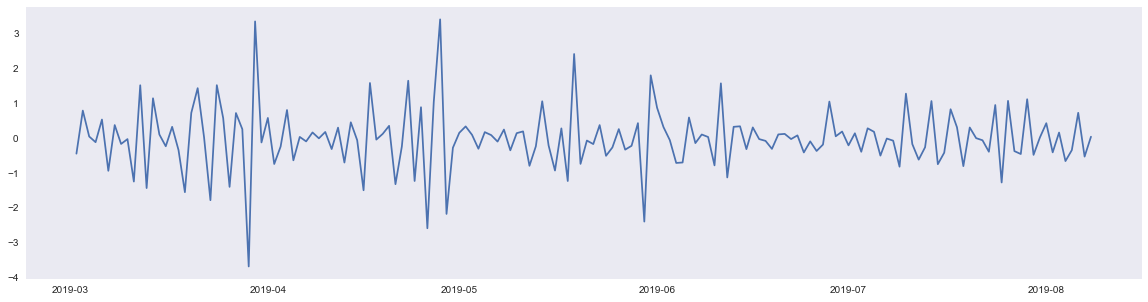

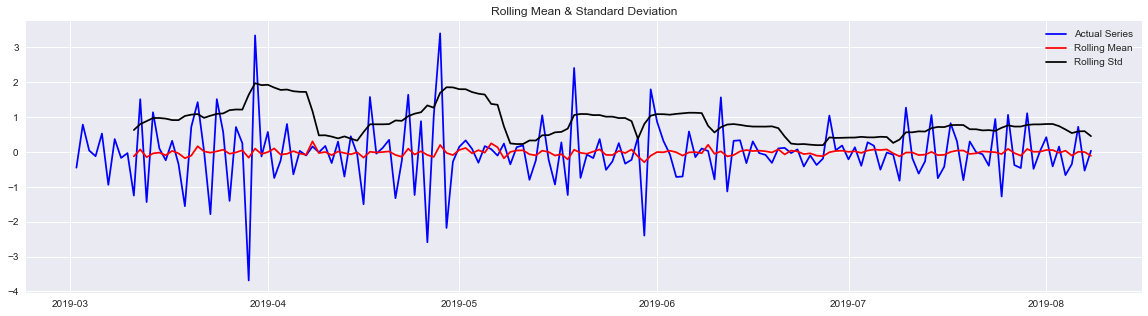

Results of Dickey-Fuller Test:
Test Statistic                -8.052657e+00
p-value                        1.725375e-12
#Lags Used                     8.000000e+00
Number of Observations Used    1.510000e+02
Critical Value (1%)           -3.474416e+00
Critical Value (5%)           -2.880878e+00
Critical Value (10%)          -2.577081e+00
dtype: float64


In [20]:
ts_differenced = difference(ts_sub)
plt.figure(figsize=(20,5))
plt.plot(ts_differenced)
plt.grid()
test_stationarity(ts_differenced)

> **Insights**
>
> Looking at the differenced results the mean and standard deviation seem to be pretty straight with not much variation with the time. The low p value for the Dickey Fuller Test shows that the corrected logarithmic transformation at differencing = 1 is stationary.

### Other Transformations

In [21]:
## REFERENCE Other Common Transformations

# y = < series >

## Log Transformation
# y_log = np.log(y)

## Square Root Transformation
# y_root = np.sqrt(y)

## Nth-Root Transformation
# y_root = np.power(y, 1/n) # n = N-th order

### Remove Trend

In [22]:
# detrended = signal.detrend(ts.values)
# plt.figure(figsize=(20,5))
# plt.plot(detrended)

### Remove Seasonality

In [23]:
## n is the length of the seasaonal window. 
# n = 12
# moving_avg = ts.rolling(n).mean()
# plt.figure(figsize=(20,5))
# plt.plot(ts)
# plt.plot(moving_avg, color='red')
# plt.title('Vibrations Data per year')
# plt.ylabel('Vibrations')
# plt.grid()

## Autocorrelations and Partial Autocorrelations

[[ go back to the top ]](#Table-of-contents)

Autocorrelation is the correlation between the data and its lags of a series. High autocorrelation means that previous time points may help predict the current value.

Partial Autocorrelation is similar but it remove the correlation contributed from intermediate lags. ie. the partial autocorrelation between $X_n$ and $X_{n-3}$ will not include the correlation effects from $X_{n-1}$ and $X_{n-2}$.

A time series ACF and PACF is often used to help define the hyperparameters for ARIMA models. We can analyse the series ACF and PACF by looking at the plots

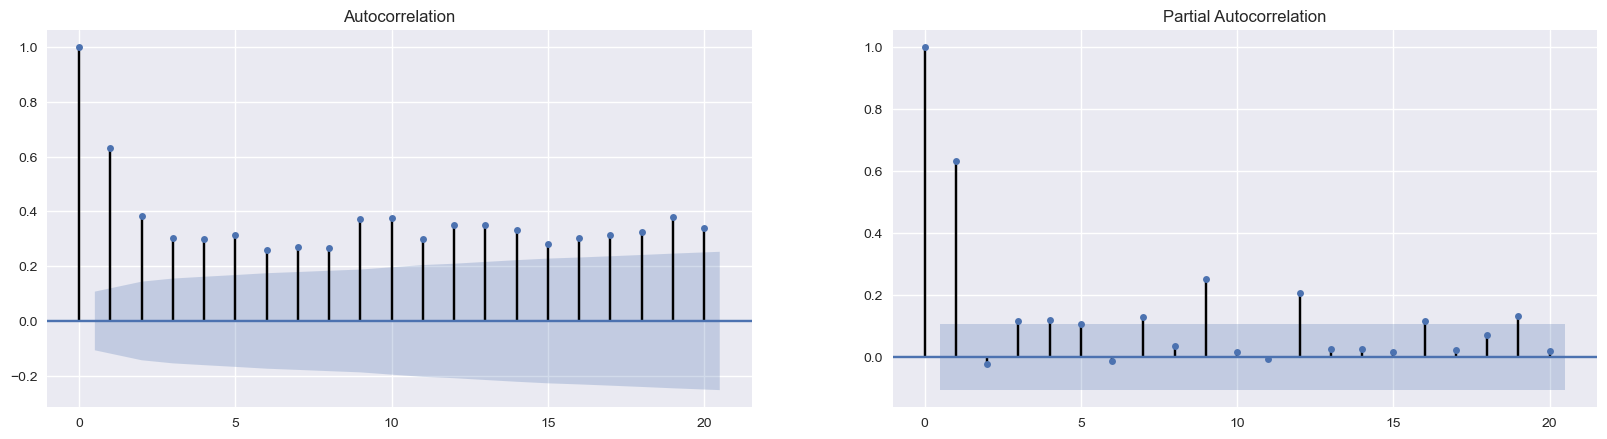

In [24]:
## Calculate the ACF and PACF for the flow series up to 20 lags
# acf_20 = acf(ts_sub, nlags=20)
# pacf_20 = pacf(ts_sub, nlags=20)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(20,5), dpi= 100)
plot_acf(ts, lags=20, ax=axes[0])
plot_pacf(ts, lags=20, ax=axes[1])
plt.show()

>The shaded area indicates values that are no significantly different from 0. Thus, in the above place, we see that ACF of the flow series decays slowly and yet have significate autocorrelations up to 20 lags, where is the PACF indicates significate up to an order of 1 lag. 

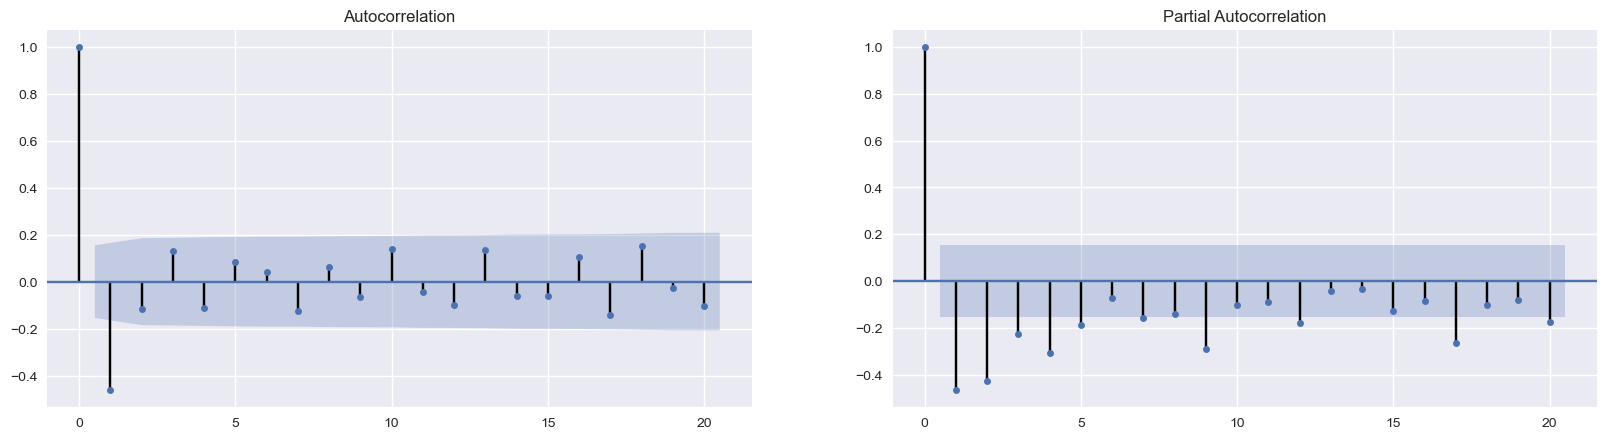

In [25]:
## Calculate the ACF and PACF for the differenced flow series up to 20 lags
# acf_20 = acf(ts_differenced, nlags=20)
# pacf_20 = pacf(ts_differenced, nlags=20)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(20,5), dpi= 100)
plot_acf(ts_differenced, lags=20, ax=axes[0])
plot_pacf(ts_differenced, lags=20, ax=axes[1])
plt.show()

>The ACF and the PACF of the differenced series show significant auto correlation up to an order of 1, and PACF up to an order of 5. 

## ARIMA Modelling

[[ go back to the top ]](#Table-of-contents)

**What are AR and MA models?** <br>

A pure Auto Regressive (AR only) model is one where y(t) depends only on its own lags. That is, y(t) is a function of the ‘lags of y(t)’. <br>

Likewise a pure Moving Average (MA only) model is one where y(t) depends only on the lagged forecast errors.

**What does the equation of an ARIMA model mean?**

An ARIMA model is one where the time series was differenced at least once to make it stationary and you combine the AR and the MA terms.

**How to find the order of the AR term (p)?**

The next step is to identify if the model needs any AR terms. You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not.

**How to find the order of the MA term (q)?**

Just like how we looked at the PACF plot for the number of AR terms, you can look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.

The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

*For a great read into explanation of ACF and PACF, and its role in ARIMA modelling - [Significance of ACF and PACF Plots In Time Series Analysis](https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8) by Jayesh Salvi.*


> **TIPS**
>
> In our previous analysis, we know that we convert the series to stationary by taking differencing in the order of 1, thus $d = 1$. In the PACF plot of the differenced series, the significant lags are up to 5 lags, thus $p=5$. Likewise, in the ACF plot, the significance is up to an order of 2, thus $q=2$.

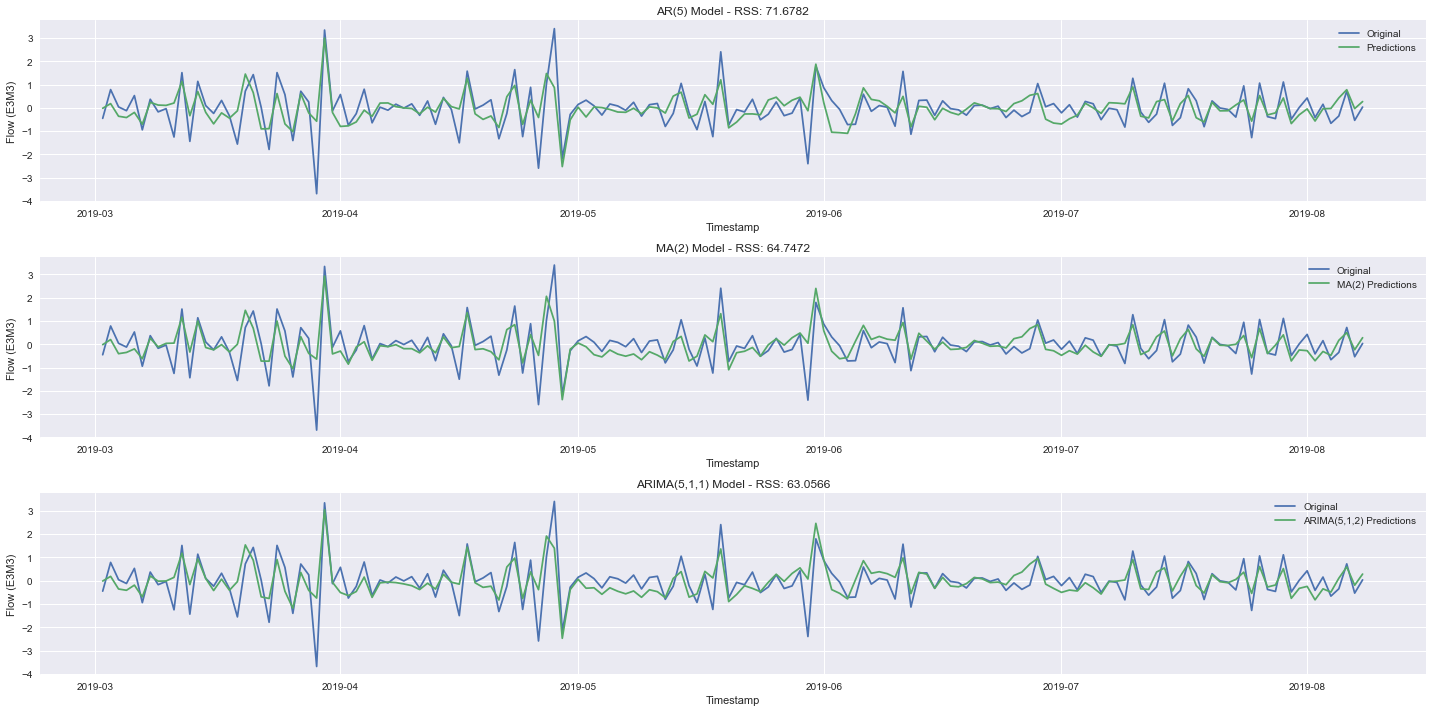

In [26]:
fig, ax = plt.subplots(3,1,figsize=(20,10))

# AR Model (p = 5)
model = ARIMA(ts_sub, order=(5,1,0))
results_AR = model.fit(disp=-1)

ax[0].plot(ts_differenced, label = 'Original')
ax[0].plot(results_AR.fittedvalues, label = 'Predictions')
ax[0].set_title('AR(5) Model - RSS: %.4f'%sum((results_AR.fittedvalues - ts_differenced)**2))
ax[0].set_xlabel('Timestamp')
ax[0].set_ylabel('Flow (E3M3)')
ax[0].legend()

# MA Model (q = 1)
model = ARIMA(ts_sub, order=(0,1,1))
results_MA = model.fit(disp=-1)

ax[1].plot(ts_differenced, label = 'Original')
ax[1].plot(results_MA.fittedvalues, label='MA(2) Predictions')
ax[1].set_title('MA(2) Model - RSS: %.4f'%sum((results_MA.fittedvalues - ts_differenced)**2))
ax[1].legend()
ax[1].set_xlabel('Timestamp')
ax[1].set_ylabel('Flow (E3M3)')

# ARIMA model (p = 5, d = 1, q = 1)
model = ARIMA(ts_sub, order=(5,1,1))
results_ARIMA = model.fit(disp=-1)

ax[2].plot(ts_differenced, label = 'Original')
ax[2].plot(results_ARIMA.fittedvalues, label = 'ARIMA(5,1,2) Predictions')
ax[2].set_title('ARIMA(5,1,1) Model - RSS: %.4f'%sum((results_ARIMA.fittedvalues - ts_differenced)**2))
ax[2].legend()
ax[2].set_xlabel('Timestamp')
ax[2].set_ylabel('Flow (E3M3)')


# plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - ts_differenced)**2))
# plt.xlabel('Timestamps')
# plt.ylabel('Flow (E3M3)')
# plt.legend()
plt.tight_layout()

> **Insights**
>
> Looking at the plots above, we see that the ARIMA model of order (p=5, d=1, q=1) have the lowest squared residuals. We will be using this model for the forecasting model.

### Forecasting "Future" Data

We will use the time after 2019-08-08 to forcast how the time series would be like if the high impact events did not happen. First we will use the ARIMA model to make a general prediction in that time frame.

In [27]:
ts_test = ts[len(ts_sub):]

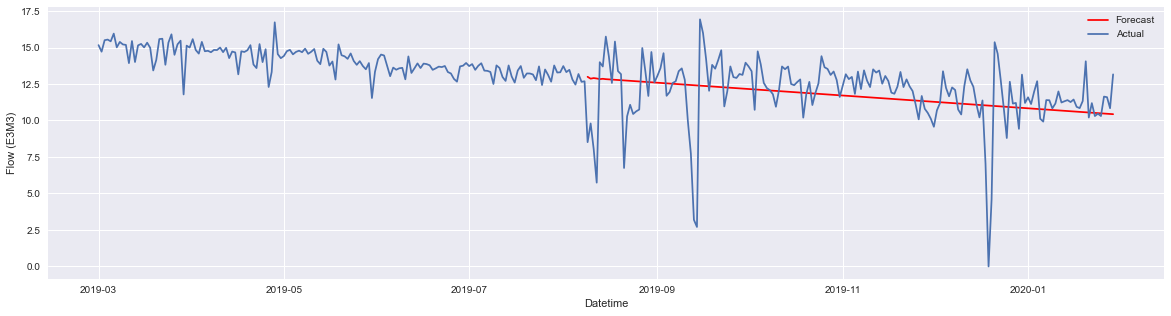

In [28]:
ts_forecast = results_ARIMA.predict(start = ts_test.index[0], end = ts_test.index[-1])

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

ts_general_forecast = pd.Series(index = pd.to_datetime([]))
# ts_general_forecast.loc[ts_sub.index] = ts_sub.values

for i, t in enumerate(ts_forecast.index):
    t_lag = t - timedelta(days=1)
    if i==0:
        inverted = ts_forecast[t] + ts[t_lag]
    else:
        inverted = ts_forecast[t] + ts_general_forecast[t_lag]
    ts_general_forecast[t] = inverted
#     print('{}:{} + {}:{}'.format(t_lag, ts_history[t_lag], t, inverted))

plt.figure(figsize=(20,5))
plt.plot(ts_general_forecast, color = 'red', label = 'Forecast')
plt.plot(ts, label = 'Actual')
plt.xlabel('Datetime')
plt.ylabel('Flow (E3M3)')
plt.legend()
plt.show()

> **Insights**
>
> We see that the predictions using the ARIMA model shows a linear decrease. This is expected since ARIMA is based on linear regression. In our flow, we also expected to see trend component, but no seasonal components. The ARIMA model forecast suggests that the trend componend is of very strong effects in this time series and that the underlying stationary component and have no high autocorrelation to the predicted points. 
>
> However, to generate more insights, we can incorporate a simulation aspect to the model. 

### Rolling Forecast

In the following, we are still trying to forecast the data to see the possible progress of the flow data. Rolling validation or walk-forward validation is a method where the model is retrained and the next value is forecasted with the newly retrained model. This is often used for validation where the forecasted data is then compared with the actual data for validation. 

However, we will not be using this method for validations, but to simulate the case senarios for the possible progress of flow in the absent of the high impact events. Here are the process:
1. Use the ARIMA trained on the 'history' to forecast the next datapoint. 
2. Using the forecasted distribution of the next data, we randomly sample from that distribution
3. Include the sampled data into the 'history'
4. Retrain model with the expanded history and repeat the process

In [29]:
ts_train = ts[:'2019-08-08']
ts_test = ts[len(ts_train):]
n = 5

history = ts_train
predictions = pd.Series(index=pd.to_datetime([]))
# walk-forward validation
for i in range(0,len(ts_test), n):
    t = ts_test.index[i]
    model = ARIMA(history, order=(5,1,1))
    model_fit = model.fit()
    output = model_fit.forecast(n)
    yhat = output[0]
    ysigma = output[1]

    try:
        t_range = pd.date_range(start=t, freq = 'd', periods = n)
        obs = ts_test.loc[t_range]
    except:
        obs = ts_test.loc[t:]
        t_range = obs.index

    for i_y, i_t in enumerate(t_range):
        predictions.loc[i_t] = yhat[i_y]
        history[i_t] = stats.norm.rvs(loc = yhat[i_y], scale = ysigma[i_y], size=1)[0]
        print('%s predicted=%f, expected=%f, simulated=%f' % (i_t, yhat[i_y], obs[i_y], history[i_t]))


2019-08-09 00:00:00 predicted=12.992062, expected=8.513960, simulated=13.316370
2019-08-10 00:00:00 predicted=12.865291, expected=9.797505, simulated=13.964402
2019-08-11 00:00:00 predicted=12.905999, expected=8.048504, simulated=12.727821
2019-08-12 00:00:00 predicted=12.877640, expected=5.739750, simulated=13.431378
2019-08-13 00:00:00 predicted=12.834208, expected=13.993663, simulated=11.522217
2019-08-14 00:00:00 predicted=12.795309, expected=13.699033, simulated=12.387588
2019-08-15 00:00:00 predicted=13.103098, expected=15.748066, simulated=12.103666
2019-08-16 00:00:00 predicted=12.753190, expected=14.388109, simulated=14.116151
2019-08-17 00:00:00 predicted=12.930810, expected=12.570134, simulated=13.189138
2019-08-18 00:00:00 predicted=12.742757, expected=15.409225, simulated=12.115527
2019-08-19 00:00:00 predicted=12.784550, expected=13.383457, simulated=12.497869
2019-08-20 00:00:00 predicted=12.719999, expected=13.172757, simulated=12.846882
2019-08-21 00:00:00 predicted=12

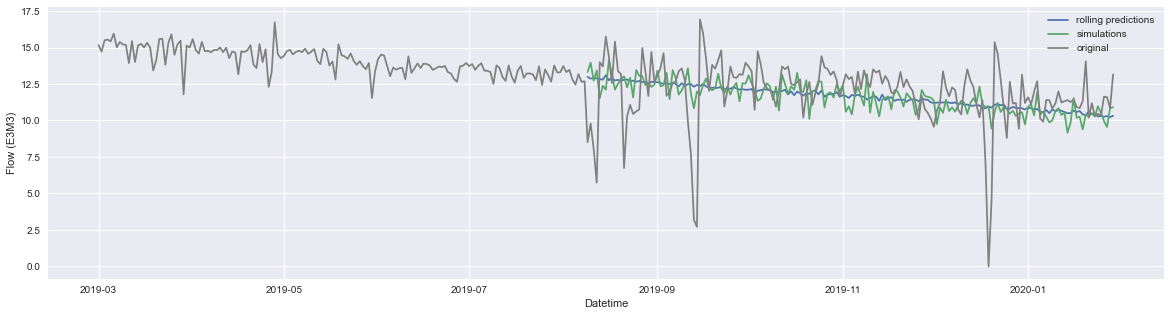

In [30]:
# plot forecasts against actual outcomes
plt.figure(figsize=(20,5))
plt.plot(predictions, label = 'rolling predictions')
plt.plot(history.loc[ts_test.index], label = 'simulations')
plt.plot(ts, c = 'grey', label = 'original')
plt.xlabel('Datetime')
plt.ylabel('Flow (E3M3)')
plt.legend()
plt.show()

## Conclusion

[[ go back to the top ]](#Table-of-contents)

In this notebook, we introduced the concept of decompositions, stationarity, and ARIMA modelling. For each of this topic, there are many tools and modelling techniques. ARIMA modelling is very common in time series analysis, there are many modelling techniques, tools, validation statistical tests that are associated with this topic. We have merely touched the very surface of this field of analysis. 

<p style="text-align: center;">© Copyright 2021 Integra Data & Analytic Solutions. All rights reserved.</p>

<p style="text-align: center;"><a href="https://www.digitalhub.io/terms-conditions")>Terms and Conditions</a></p>